In [1]:
import os
import joblib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Sklearn imports
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Classical models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Neural network (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.backend import clear_session

from itertools import product

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sns.set_theme(context="talk", style="whitegrid", palette="deep")

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Dataset

## Load Dataset

In [3]:
data_path = 'data/data_extended_clean.csv'
data = pd.read_csv(data_path)

print("\nData summary:")
print(data.describe())


Data summary:
        run_order   replicate  pressure  nozzle_diameter  robot_speed  \
count  732.000000  732.000000     732.0            732.0   732.000000   
mean    36.737705    6.500000      50.0              8.0    15.409836   
std     24.890393    3.454413       0.0              0.0     5.271435   
min      1.000000    1.000000      50.0              8.0     8.000000   
25%     16.000000    3.750000      50.0              8.0    12.000000   
50%     31.000000    6.500000      50.0              8.0    16.000000   
75%     53.000000    9.250000      50.0              8.0    20.000000   
max     99.000000   12.000000      50.0              8.0    25.000000   

               do  extrusion_speed  slice_height  layer_height  layer_width  \
count  732.000000       732.000000         732.0    732.000000   732.000000   
mean    43.885246        10.388525           5.0      5.578634     9.629303   
std     19.144292         1.914429           0.0      0.498745     1.412896   
min     11.

## Train-Test Split

In [4]:
# Define features and target

feature_scaler = RobustScaler()
X = data[['robot_speed', 'height_difference', 'width_difference']]
y = data[['extrusion_speed']]

# Reserve an independent test set (20%) and use 80% for training/cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (585, 3)
Test set shape: (147, 3)


In [5]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Neural Network Model

In [34]:
SAVE_DIR = 'model'
FILE_NAME = 'mycoprint_ANN'

K_FOLD = True
TRAIN_MODEL = True
SAVE_MODEL = True
LOAD_MODEL = True

BATCH_SIZE = 64

## ANN Model

In [ ]:
def create_nn_model(input_dim, model_depth=2,layer_size=32, l1_rate=1e-3, l2_rate=1e-3, dropout_rate=0.0, learning_rate=5e-1):
	model = Sequential()
	# First hidden layer
	model.add(Input((input_dim,)))
	for _ in range(model_depth):
		model.add(Dense(layer_size, activation='elu',
						kernel_regularizer=l1_l2(l1_rate, l2_rate)))
		model.add(Dropout(dropout_rate))
	# Output layer
	model.add(Dense(1))
	
	model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
	return model

## K-fold Cross-Validation

In [ ]:
import os
import json

if K_FOLD:
	# Set up KFold cross-validation for the NN
	kf = KFold(n_splits=5, shuffle=True, random_state=42)
	nn_cv_metrics = []  # List to store metrics for each fold
	fold = 1

	for train_index, val_index in kf.split(X_train):
		# Split the training set into fold-specific training and validation sets
		X_tr_fold = X_train.iloc[train_index]
		X_val_fold = X_train.iloc[val_index]
		y_tr_fold = y_train.iloc[train_index]
		y_val_fold = y_train.iloc[val_index]
		
		# Fit a scaler on the fold's training data and transform both training and validation data
		scaler_nn = RobustScaler()
		X_tr_fold_scaled = scaler_nn.fit_transform(X_tr_fold)
		X_val_fold_scaled = scaler_nn.transform(X_val_fold)
		
		# Build and train the NN model
		model_nn = create_nn_model(input_dim=X_tr_fold_scaled.shape[1])
		
		early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-5, restore_best_weights=True, verbose=0)
		reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4, verbose=0)
		
		history = model_nn.fit(X_tr_fold_scaled, y_tr_fold, epochs=1000, batch_size=BATCH_SIZE, verbose=0,
							   validation_data=(X_val_fold_scaled, y_val_fold), 
							   callbacks=[reduce_lr, early_stopping])
		
		# Evaluate the model on the validation fold
		y_val_pred = model_nn.predict(X_val_fold_scaled, verbose=0)
		
		mse_fold = mean_squared_error(y_val_fold, y_val_pred)
		mae_fold = mean_absolute_error(y_val_fold, y_val_pred)
		rmse_fold = np.sqrt(mse_fold)
		r2_fold = r2_score(y_val_fold, y_val_pred)
		
		# Store metrics for this fold
		fold_metrics = {'fold': fold, 'mse': mse_fold, 'mae': mae_fold, 'rmse': rmse_fold, 'r2': r2_fold}
		nn_cv_metrics.append(fold_metrics)
		
		# Print metrics for this fold
		print(f"Fold {fold} Neural Network Validation Metrics:")
		print(f"   R2: {r2_fold:.4f}, RMSE: {rmse_fold:.4f}, MSE: {mse_fold:.4f}, MAE: {mae_fold:.4f}")
		print("---------------------")
		fold += 1

	# Compute average metrics across folds
	avg_mse = np.mean([m['mse'] for m in nn_cv_metrics])
	avg_mae = np.mean([m['mae'] for m in nn_cv_metrics])
	avg_rmse = np.mean([m['rmse'] for m in nn_cv_metrics])
	avg_r2 = np.mean([m['r2'] for m in nn_cv_metrics])

	print("Average Neural Network Validation Metrics (5-Fold CV):")
	print(f"   R2: {avg_r2:.4f}, RMSE: {avg_rmse:.4f}, MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

	# Prepare a dictionary with per-fold and average metrics.
	cv_results = {
		"folds": nn_cv_metrics,
		"average": {
			"mse": avg_mse,
			"mae": avg_mae,
			"rmse": avg_rmse,
			"r2": avg_r2
		}
	}
	
	# Create the output folder if it does not exist.
	os.makedirs("out", exist_ok=True)
	
	# Export the cross-validation metrics to a JSON file.
	with open(f"out/{FILE_NAME}_k-fold.json", "w") as f:
		json.dump(cv_results, f, indent=4)

clear_session()

Fold 1 Neural Network Validation Metrics:
   R2: 0.9146, RMSE: 0.5219, MSE: 0.2723, MAE: 0.3980
---------------------
Fold 2 Neural Network Validation Metrics:
   R2: 0.9361, RMSE: 0.4991, MSE: 0.2491, MAE: 0.3777
---------------------
Fold 3 Neural Network Validation Metrics:
   R2: 0.9264, RMSE: 0.5146, MSE: 0.2648, MAE: 0.3735
---------------------
Fold 4 Neural Network Validation Metrics:
   R2: 0.9234, RMSE: 0.5475, MSE: 0.2997, MAE: 0.4136
---------------------
Fold 5 Neural Network Validation Metrics:
   R2: 0.8884, RMSE: 0.5701, MSE: 0.3250, MAE: 0.4185
---------------------
Average Neural Network Validation Metrics (5-Fold CV):
   R2: 0.9178, RMSE: 0.5306, MSE: 0.2822, MAE: 0.3963


## Train Model

In [ ]:
if TRAIN_MODEL:
	nn = create_nn_model(input_dim=X_train_scaled.shape[1])

	early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
	reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-3, verbose=1)

	history = nn.fit(X_train_scaled, y_train, epochs=1000, batch_size=BATCH_SIZE, verbose=2, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/1000
8/8 - 1s - 90ms/step - loss: 842.9203 - val_loss: 16.7763 - learning_rate: 0.5000
Epoch 2/1000
8/8 - 0s - 13ms/step - loss: 62.3216 - val_loss: 23.2685 - learning_rate: 0.5000
Epoch 3/1000
8/8 - 0s - 13ms/step - loss: 16.6303 - val_loss: 16.0407 - learning_rate: 0.5000
Epoch 4/1000
8/8 - 0s - 13ms/step - loss: 11.5390 - val_loss: 8.5443 - learning_rate: 0.5000
Epoch 5/1000
8/8 - 0s - 12ms/step - loss: 9.1052 - val_loss: 9.6229 - learning_rate: 0.5000
Epoch 6/1000
8/8 - 0s - 13ms/step - loss: 8.7688 - val_loss: 8.4470 - learning_rate: 0.5000
Epoch 7/1000
8/8 - 0s - 13ms/step - loss: 8.2350 - val_loss: 7.9527 - learning_rate: 0.5000
Epoch 8/1000
8/8 - 0s - 13ms/step - loss: 8.0073 - val_loss: 7.7009 - learning_rate: 0.5000
Epoch 9/1000
8/8 - 0s - 12ms/step - loss: 7.7831 - val_loss: 7.8175 - learning_rate: 0.5000
Epoch 10/1000
8/8 - 0s - 12ms/step - loss: 7.7915 - val_loss: 7.5937 - learning_rate: 0.5000
Epoch 11/1000
8/8 - 0s - 13ms/step - loss: 7.5694 - val_loss: 7.4063 - 

## Save/Load Model and Scaler (Optional)

In [ ]:
if SAVE_MODEL:
	os.makedirs(SAVE_DIR, exist_ok=True)

	# Save the complete Keras model in .keras format (this includes weights, architecture, and optimizer state)
	nn.save(f"{SAVE_DIR}/{FILE_NAME}_model.keras")

	# Save the scaler using joblib
	joblib.dump(scaler, f"{SAVE_DIR}/{FILE_NAME}_scaler.pkl")

	print("Model and Scaler saved successfully!")
else:
	print("Skipped saving Model and Scaler.")

Model and Scaler saved successfully!


In [ ]:
if LOAD_MODEL:
	nn = load_model(f"{SAVE_DIR}/{FILE_NAME}_model.keras")
	scaler = joblib.load(f"{SAVE_DIR}/{FILE_NAME}_scaler.pkl")

	print("Model and Scaler loaded successfully!")
else:
	print("Skipped loading Model and Scaler.")

Model and Scaler loaded successfully!


## Evaluate Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model Performance Comparison:
        Linear Regression: R2: 0.8787, RMSE: 0.7022, MSE: 0.4931, MAE: 0.5568
    Polynomial Regression: R2: 0.9106, RMSE: 0.6028, MSE: 0.3634, MAE: 0.4642
                      ANN: R2: 0.9222, RMSE: 0.5624, MSE: 0.3163, MAE: 0.4471


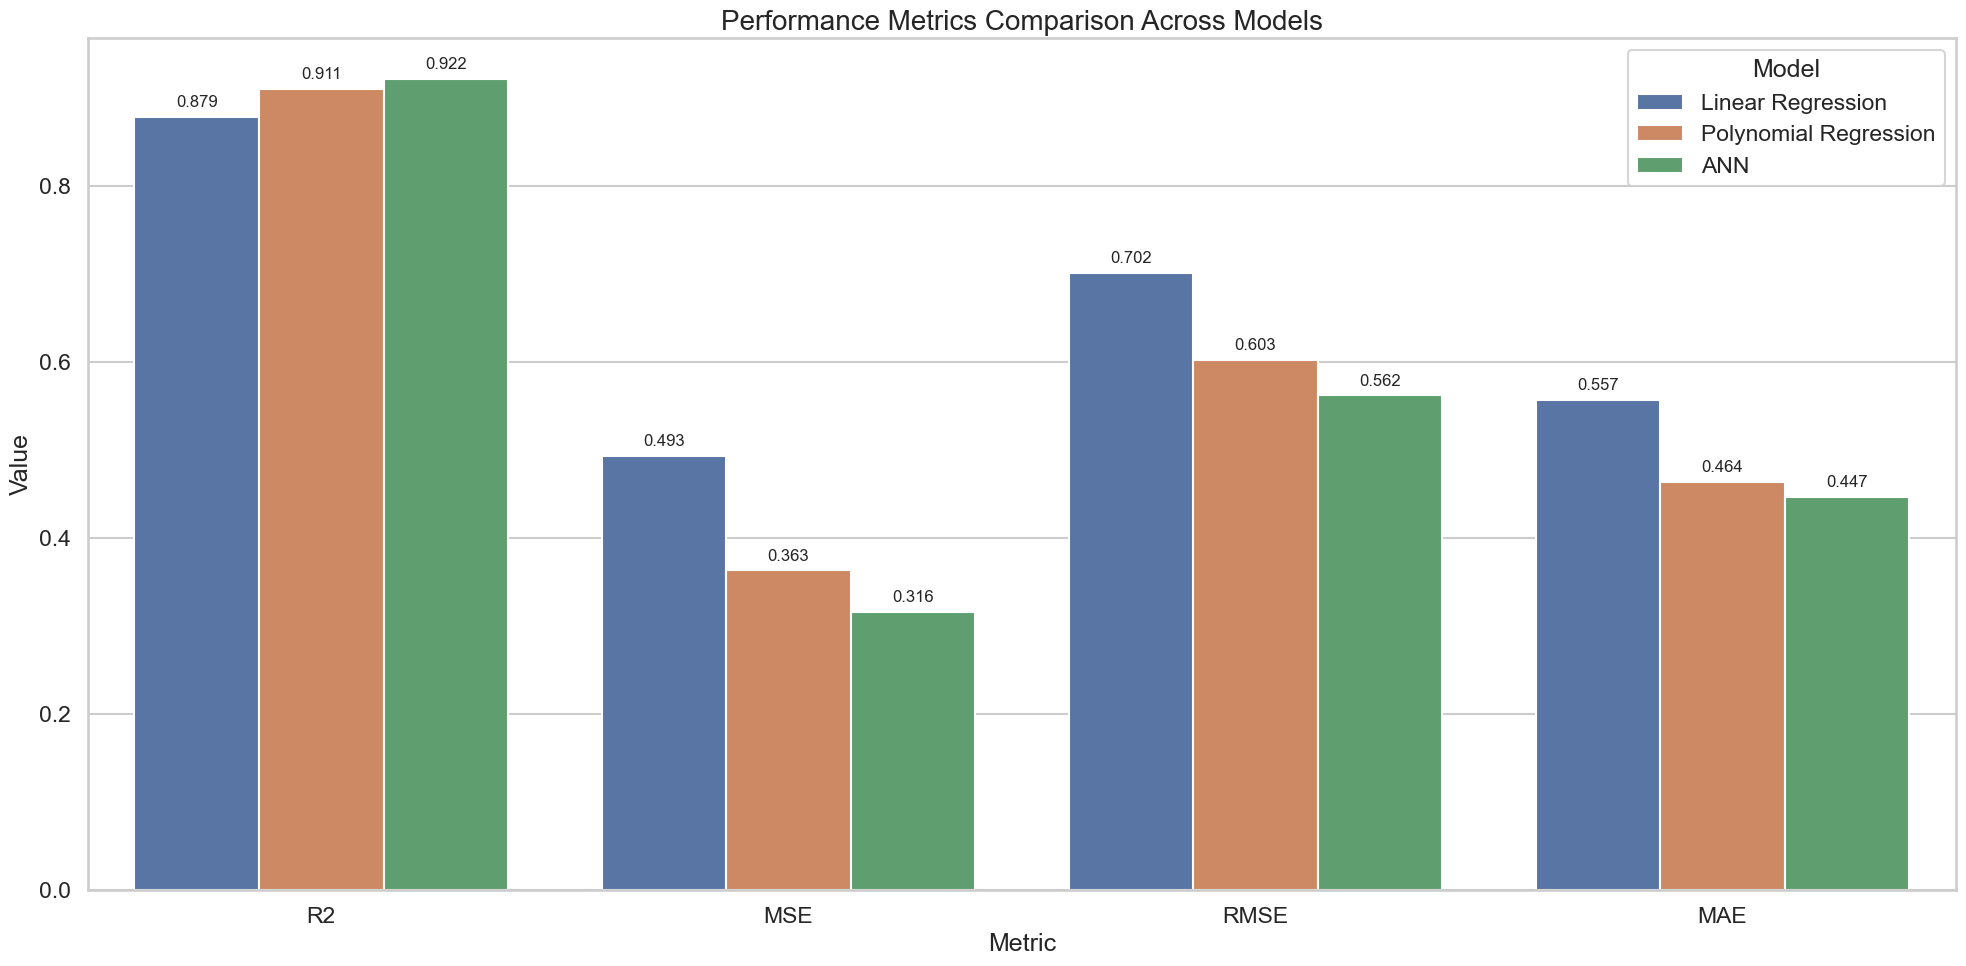

In [62]:
# =============================================================================
# (1) Train Classical Models
# =============================================================================
# Linear Regression: baseline linear model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# Gradient Boosting Regression: ensemble method building trees sequentially
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# Random Forest Regression: ensemble method averaging decision trees
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Polynomial Regression (3rd degree): to capture non-linear relationships
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('lin', LinearRegression())
])
poly_reg.fit(X_train, y_train)
y_pred_poly = poly_reg.predict(X_test)

# =============================================================================
# (2) ANN Predictions
# =============================================================================
# Scale the test features using the same scaler as for training the ANN,
# then generate predictions from the ANN.
X_test_scaled = scaler.transform(X_test)
y_pred_ann = nn.predict(X_test_scaled).flatten()

# =============================================================================
# (3) Compute and Print Performance Metrics
# =============================================================================
# Collect predictions from selected models in a dictionary.
# Uncomment additional models if desired.
models = {
    'Linear Regression': y_pred_lr,
    'Polynomial Regression': y_pred_poly,
    # 'Gradient Boosting': y_pred_gbr,
    # 'Random Forest': y_pred_rf,
    'ANN': y_pred_ann
}

# Compute metrics for each model and print the results.
metrics = {}
print("Model Performance Comparison:")
for name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    metrics[name] = {"R2": r2, "MSE": mse, "RMSE": rmse, "MAE": mae}
    print(f"{name:>25}: R2: {r2:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

# =============================================================================
# (4) Plot Grouped Bar Chart for Performance Metrics
# =============================================================================
# Convert the metrics dictionary to a DataFrame and reshape it for plotting.
metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'Model'})
melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Create the grouped bar chart using seaborn.
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="Metric", y="Value", hue="Model", data=melted, ax=ax)
ax.set_title("Performance Metrics Comparison Across Models", fontsize=20)

# ─── Annotate each bar with its numeric value ─────────────────────────────────
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue
    ax.annotate(f'{height:.3f}',                # format to 2 decimal places
                xy=(p.get_x() + p.get_width() / 2, height),  # position at top center of bar
                xytext=(0, 5),                 # small vertical offset
                textcoords='offset points',   # interpret xytext in points
                ha='center', va='bottom',      # center horizontally, align text bottom at the point
                fontsize=12)

plt.tight_layout()
plt.savefig("out/performance_metrics.svg", format="svg", bbox_inches='tight')
plt.show()

## Plot Residiuals (Predicted-Observed)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


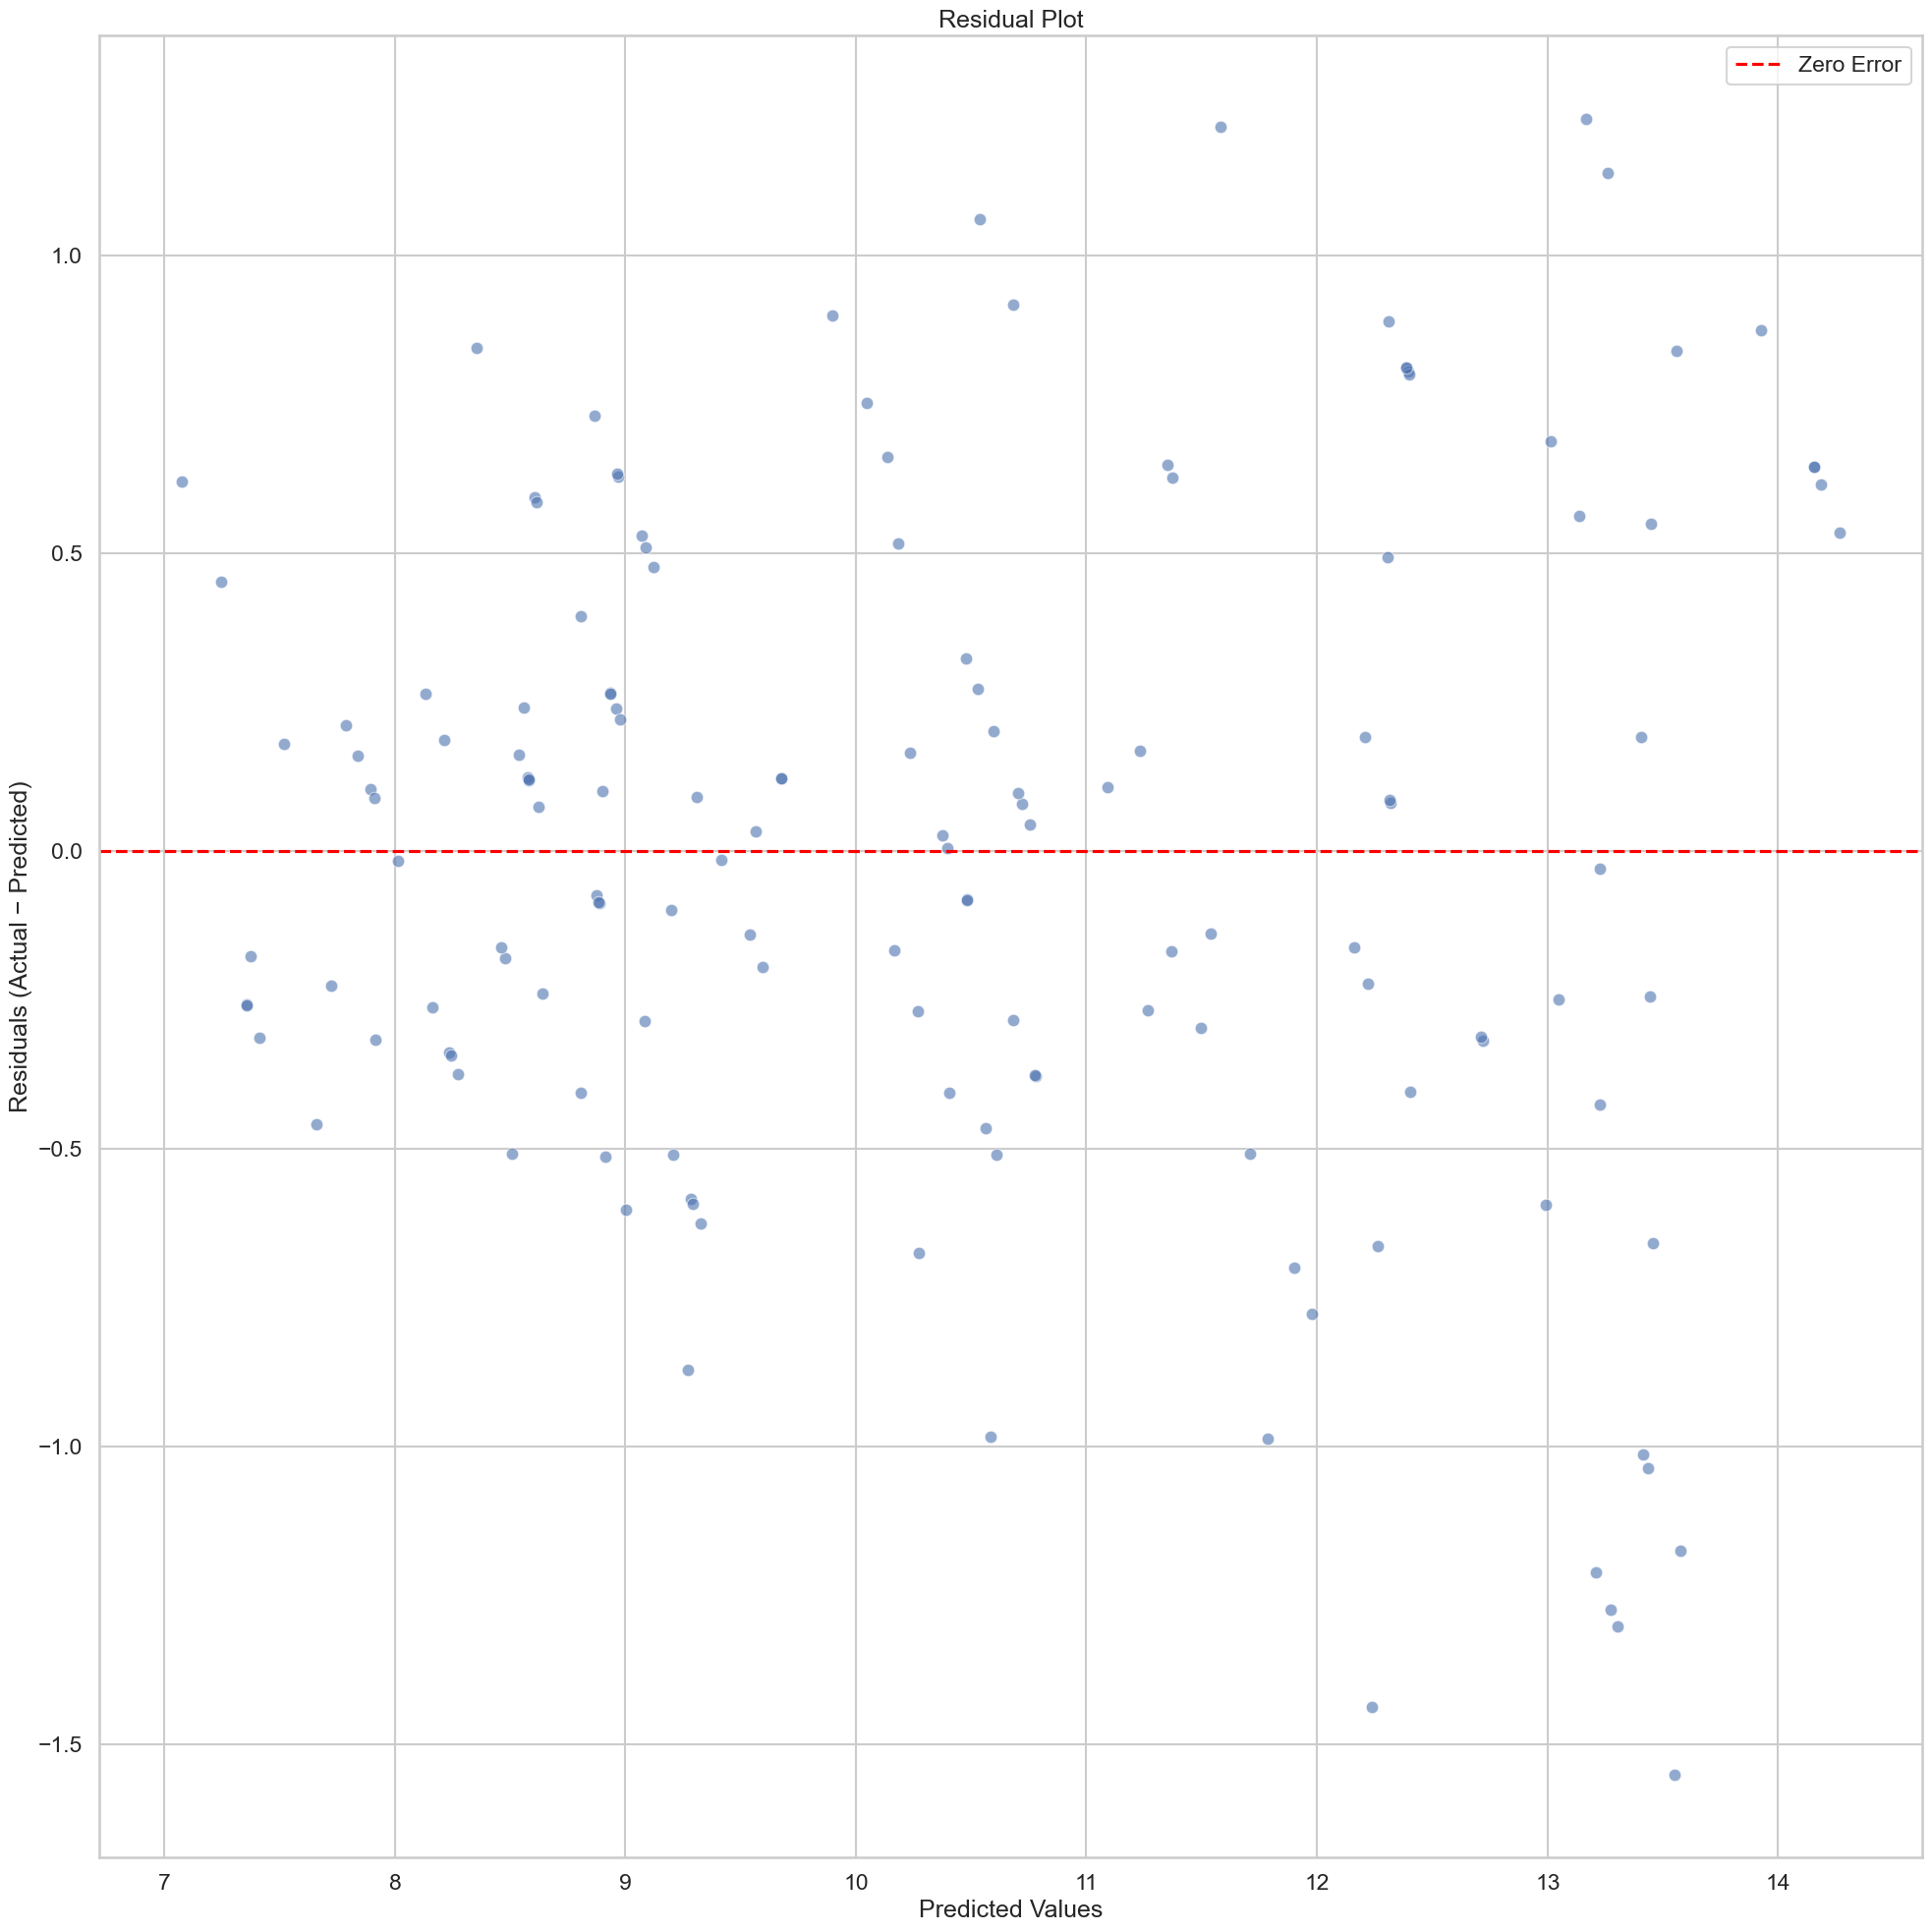

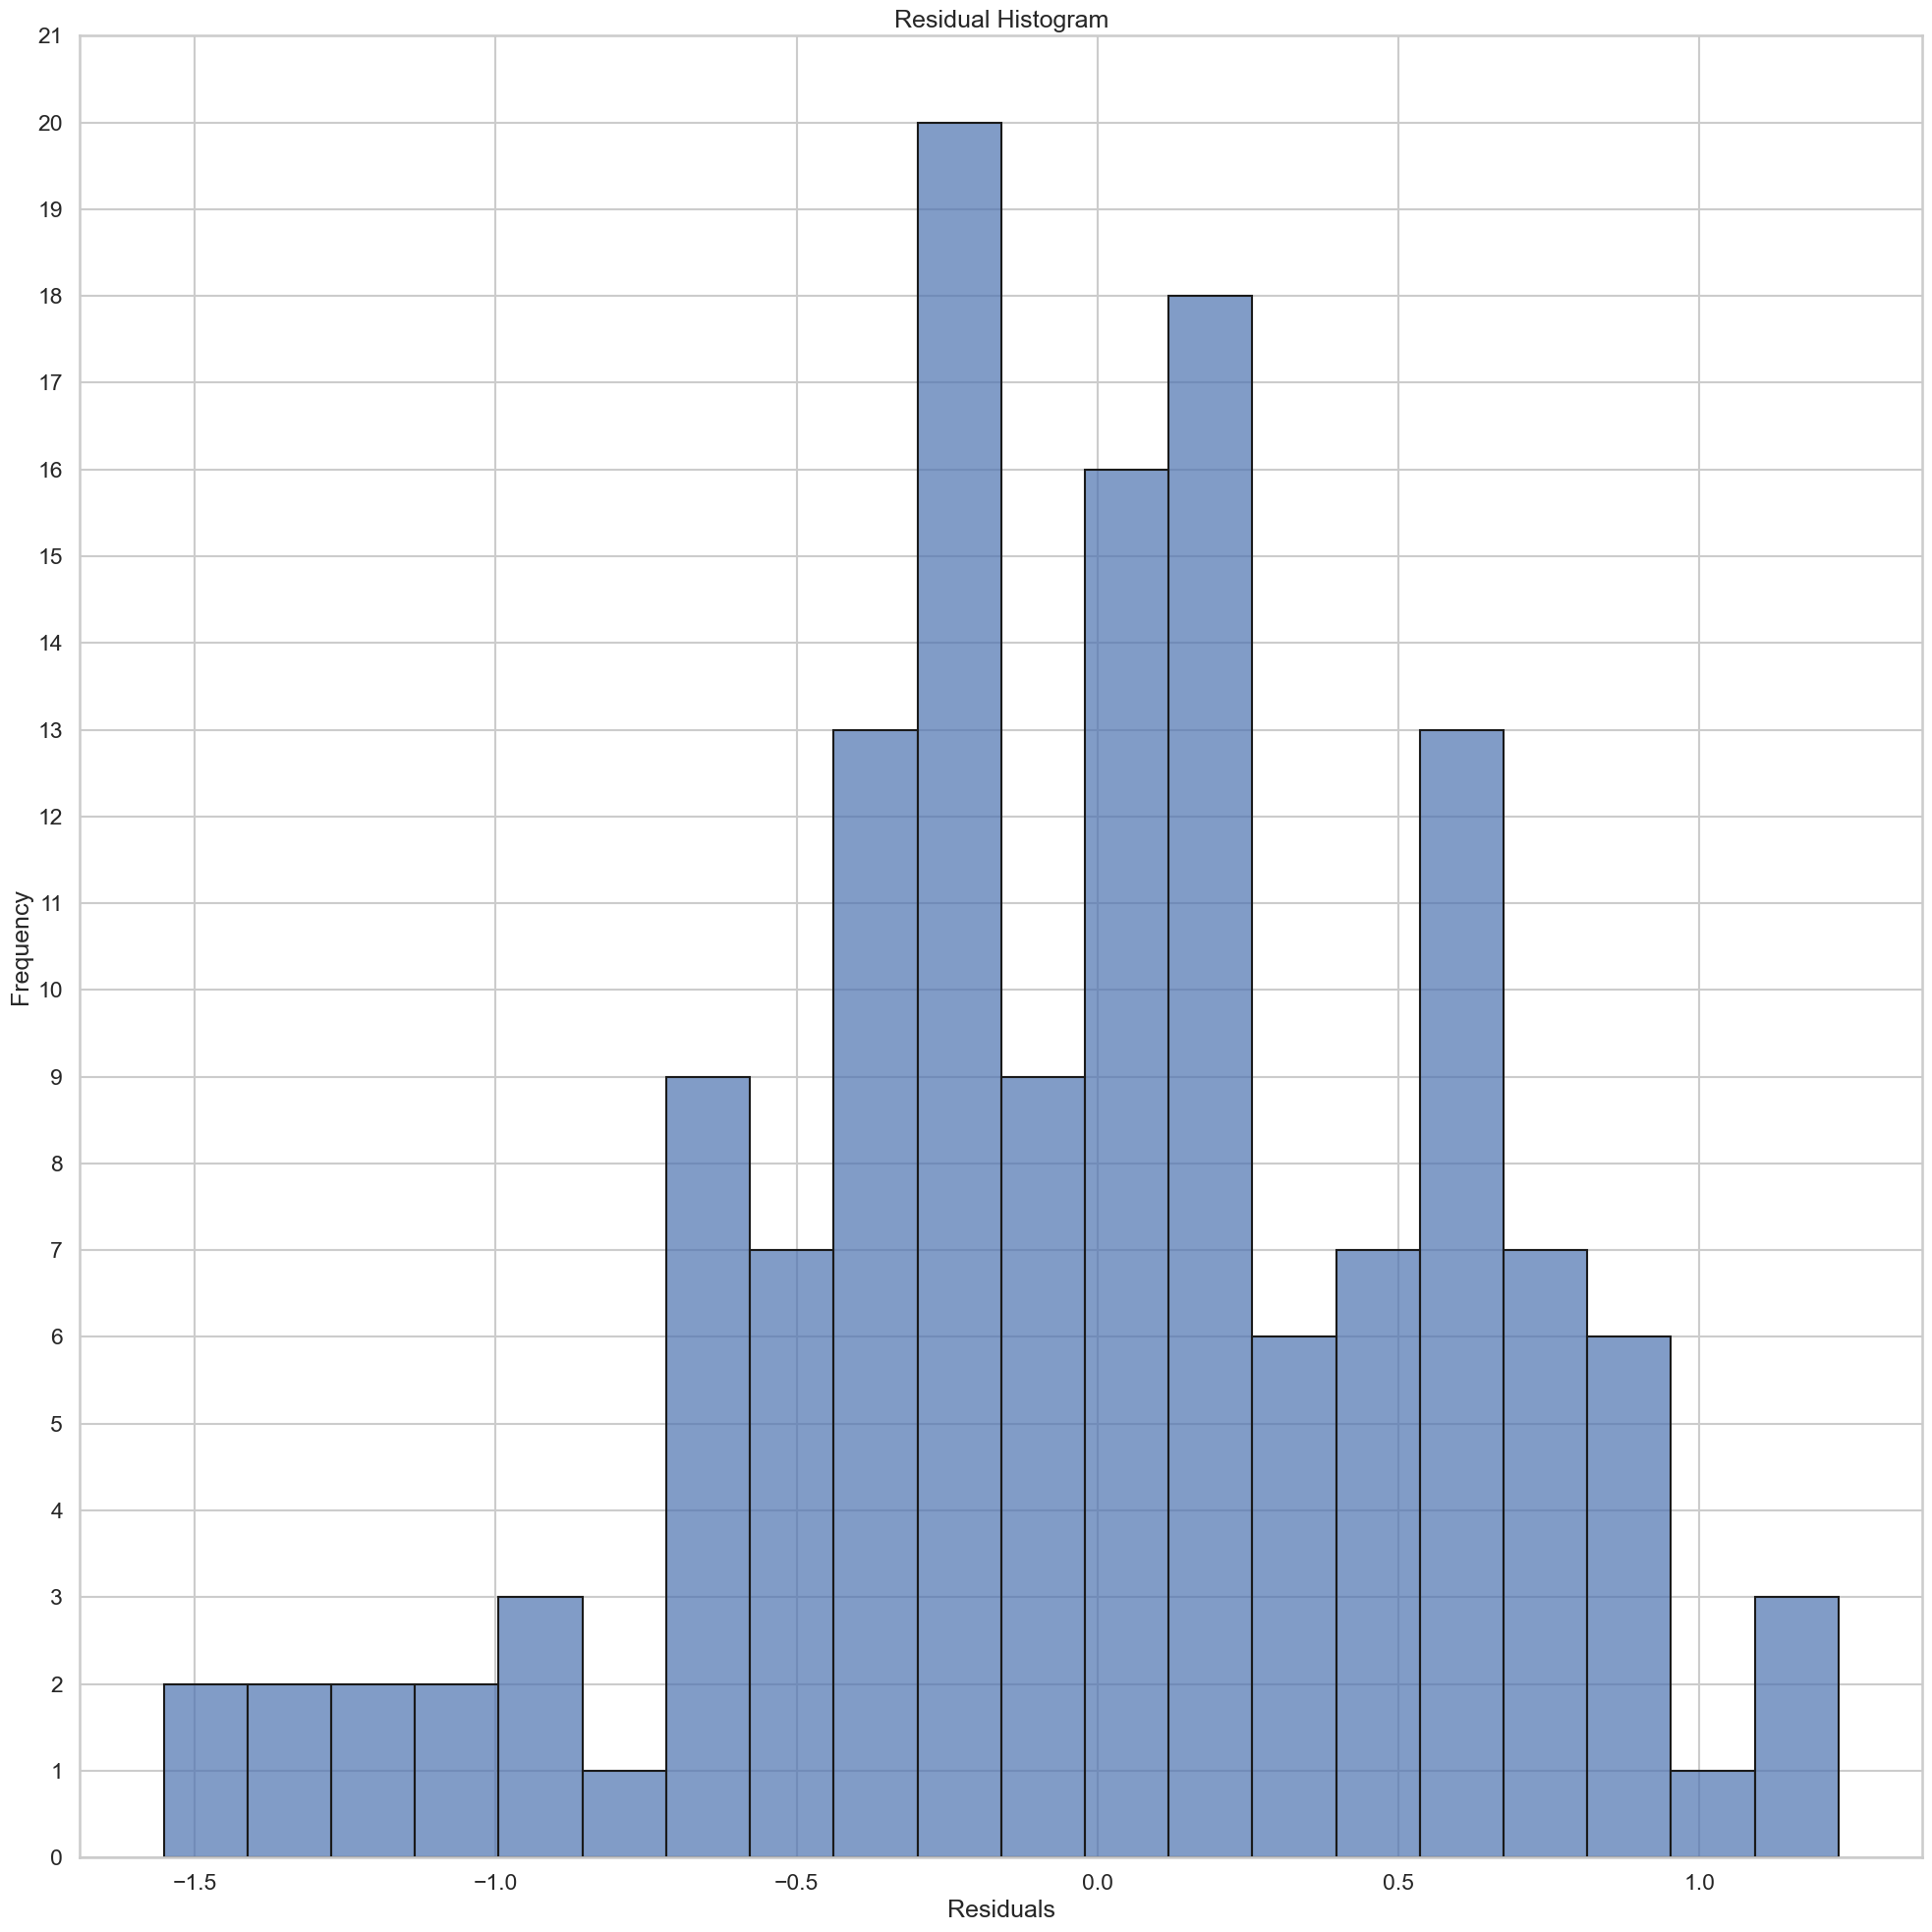

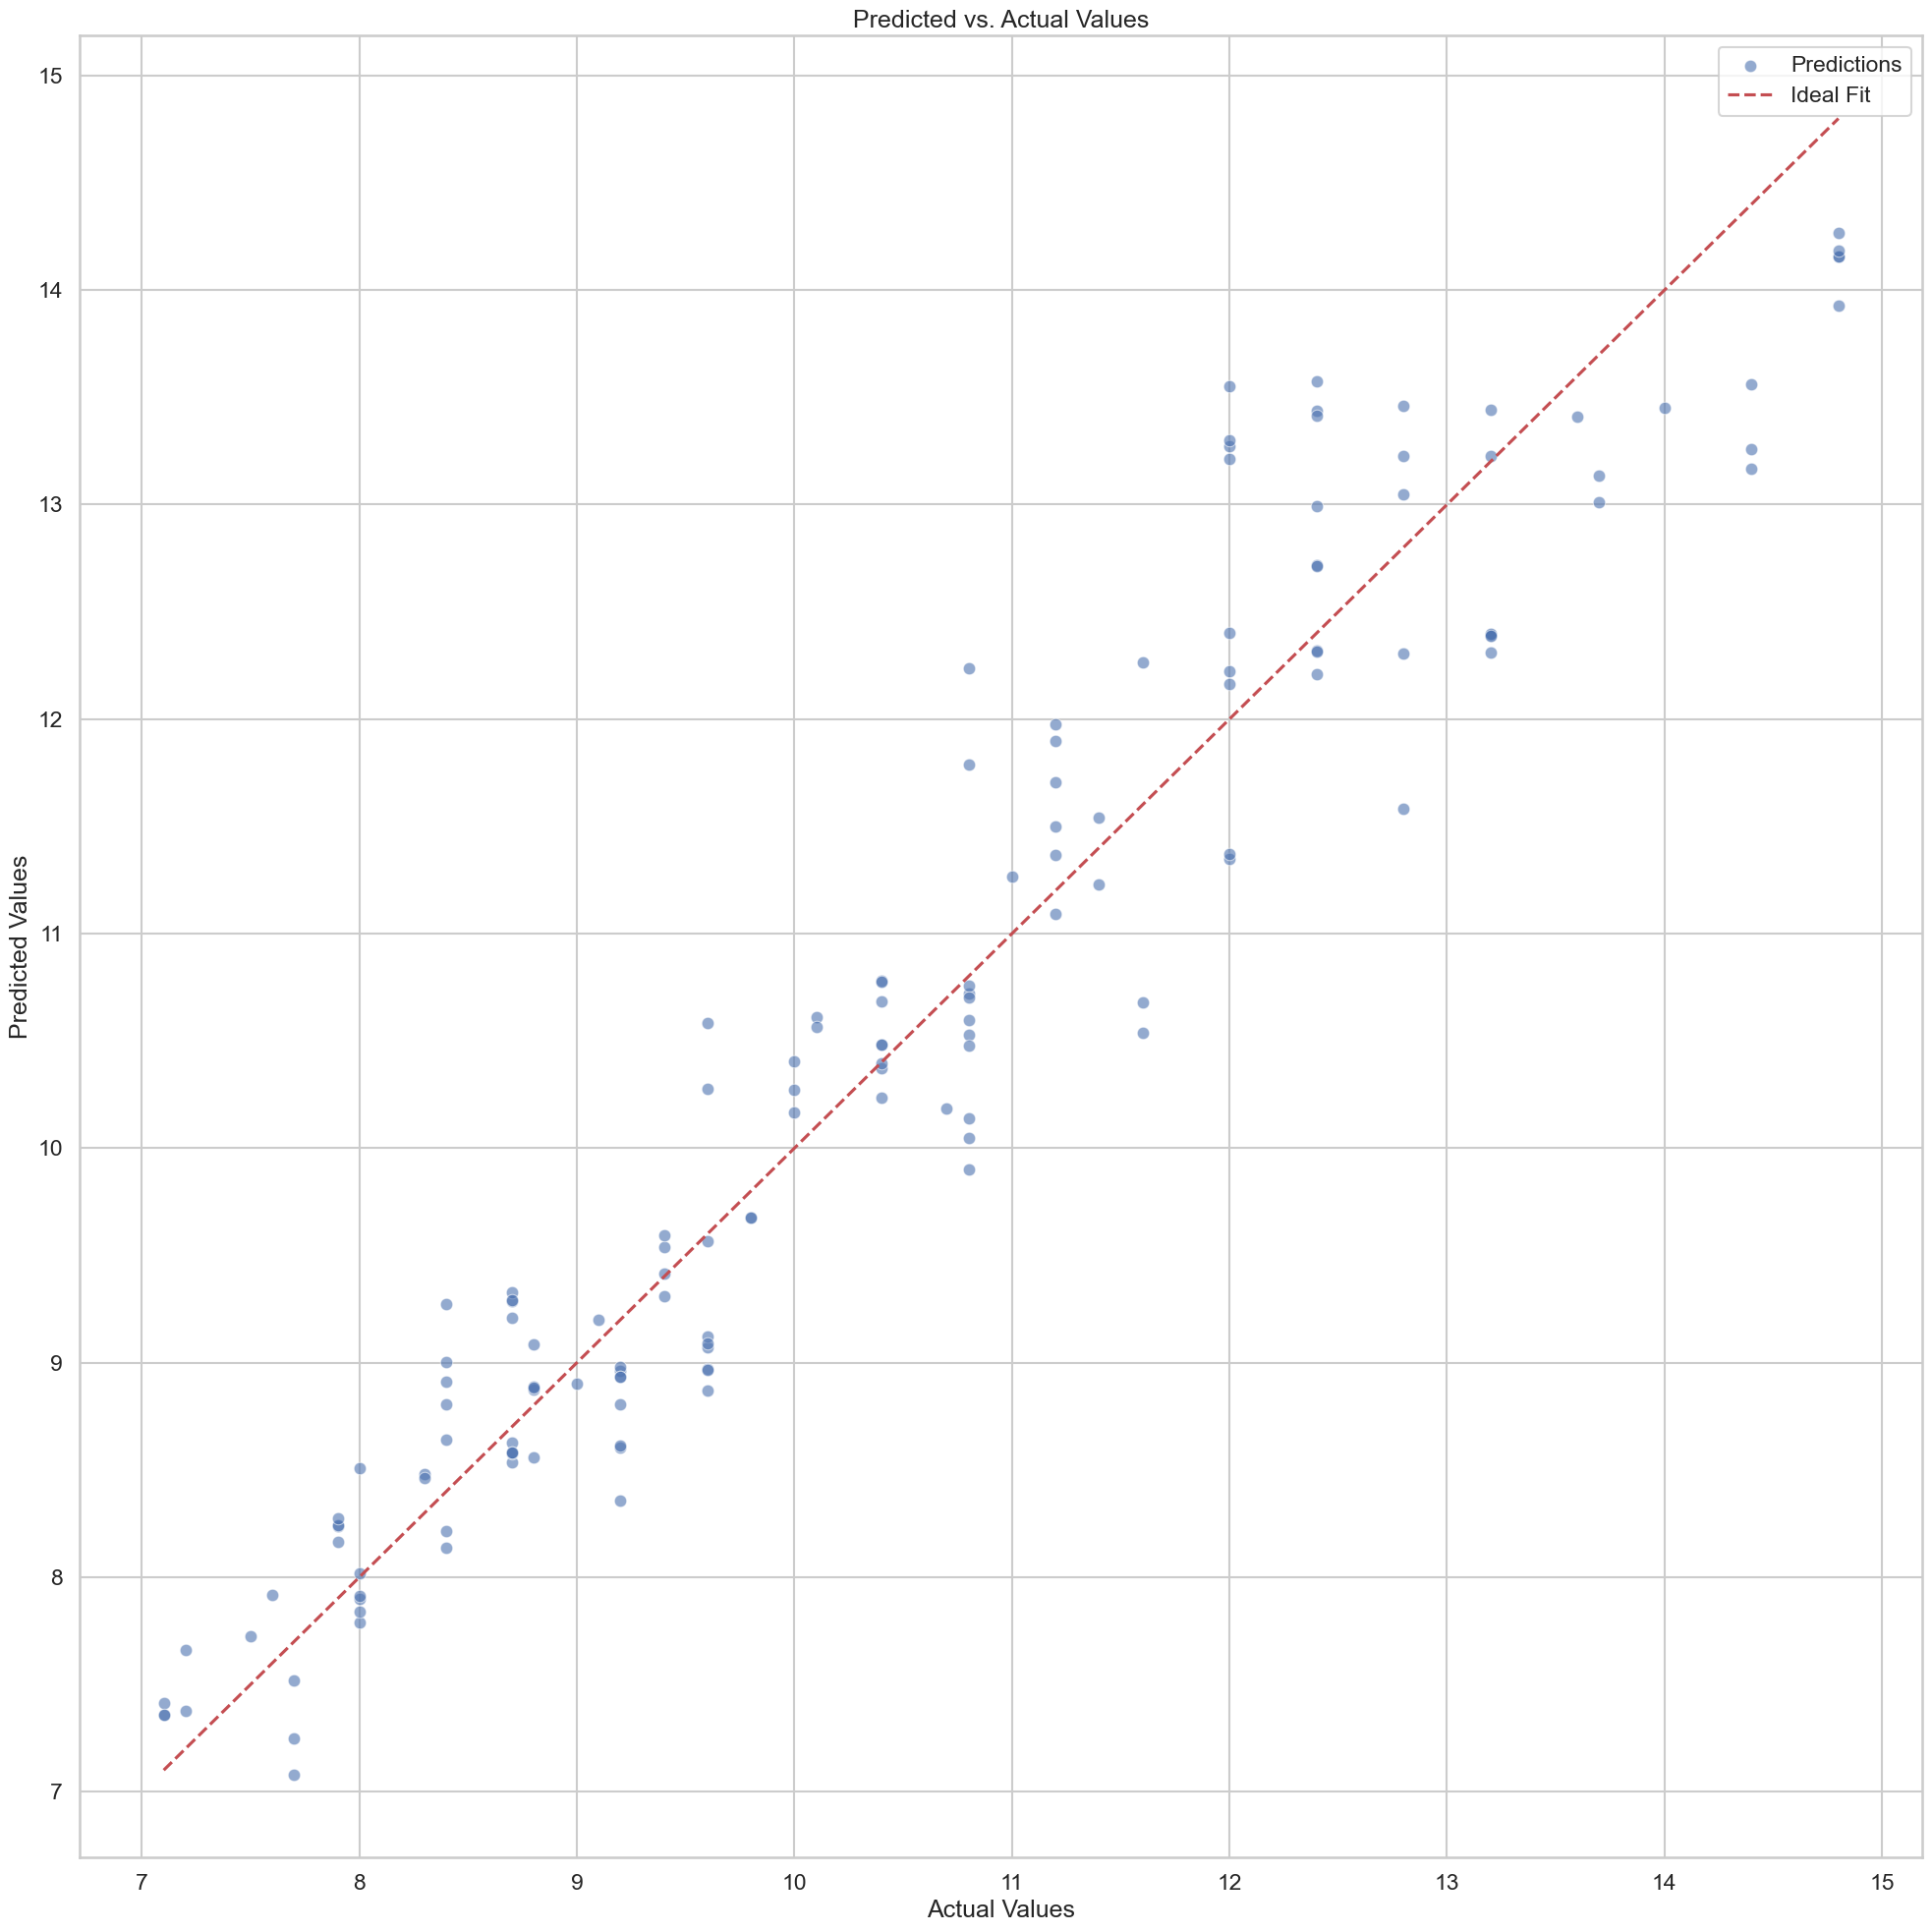

<Figure size 2000x2000 with 0 Axes>

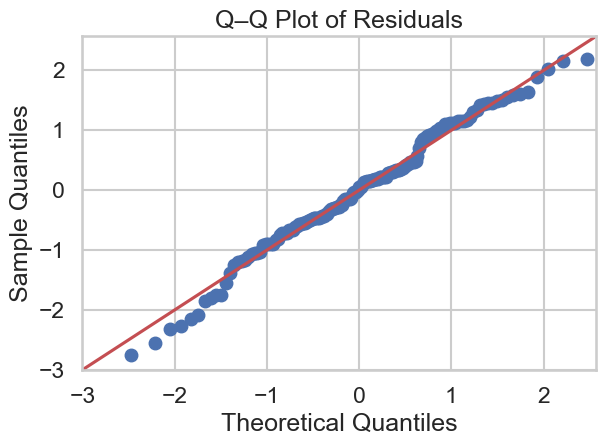

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from matplotlib.ticker import MultipleLocator

# 1) Compute predictions & residuals
y_test_pred = nn.predict(X_test_scaled).flatten()
y_test_arr  = np.array(y_test).flatten()
residuals   = y_test_arr - y_test_pred

# ----- Plot 1: Residual Scatter -----
plt.figure(figsize=(20, 20))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual − Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Plot 2: Residual Histogram -----
plt.figure(figsize=(20, 20))
sns.histplot(residuals, bins=20, edgecolor='k', alpha=0.7)

ax = plt.gca()  # get current axes
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Residual Histogram")

# Force y-axis ticks at every integer
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.grid(True)
plt.tight_layout()
plt.show()

# ----- Plot 3: Predicted vs Actual -----
plt.figure(figsize=(20, 20))
sns.scatterplot(x=y_test_arr, y=y_test_pred, alpha=0.6, label="Predictions")
min_val, max_val = y_test_arr.min(), y_test_arr.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Plot 4: Q–Q Plot of Residuals -----
plt.figure(figsize=(20, 20))
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q–Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()